## Bridging Schema

This notebook demonstrates the Bridging Schema design pattern


### Create dataset

Let's create a dataset by simulating the scenario described in the book

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 10)})

def set_payment_type(prob):
    # 30% of transactions are cash
    if prob < 0.3:
        return 'Cash'

    # stretch the remaining 0.3-1.0 to 0-1
    prob = (prob-0.3)/0.7
    if prob < 0.1:
        return 'Gift'
    if prob < 0.4:
        return 'Debit'
    return 'Credit'

def create_dataset(N, is_old_format):
    order_amount = 5 + np.abs(np.random.normal(scale=10, size=N)) # 5+, peaks at 15
    order_distance = 1 + np.random.rand(N)*4  # 1-5
    payment_type = np.random.rand(N)
    
    df = pd.DataFrame.from_dict({
        'order_amount' : np.round(order_amount, 2),
        'order_distance': np.round(order_distance, 1),
        'payment_type': np.vectorize(set_payment_type)(payment_type),
        'tip': np.zeros_like(order_amount)
    })
    
    df.loc[df['payment_type'] == 'Cash', 'tip'] = 0.2
    df.loc[df['payment_type'] == 'Gift', 'tip'] = 0.1
    df.loc[df['payment_type'] == 'Debit',  'tip'] = 0.15
    df.loc[df['payment_type'] == 'Credit', 'tip'] = 0.25
    
    df['tip'] = np.round(df['tip'] * df['order_amount'] + 0.5*df['order_distance'], 1)
    
    if is_old_format:
        df.loc[df['payment_type'] != 'Cash', 'payment_type'] = 'Card'
    
    return df

In [2]:
df = create_dataset(5, False)
df

,order_amount,order_distance,payment_type,tip
0,19.01,3.4,Debit,4.6
1,9.09,1.8,Cash,2.7
2,11.85,1.1,Credit,3.5
3,17.03,3.0,Credit,5.8
4,17.87,3.2,Gift,3.4


In [3]:
df = create_dataset(5, True)
df

,order_amount,order_distance,payment_type,tip
0,17.38,3.7,Cash,5.3
1,28.28,3.0,Card,5.7
2,22.40,3.8,Card,7.5
3,18.58,1.6,Card,5.4
4,7.65,4.1,Cash,3.6


## Bridging

Create dataset of 5000 new transactions and 1 million old transactions

In [20]:
df_new = create_dataset(5000, False)
df_old = create_dataset(1000*1000, True)

### How many samples do we need to evaluate properly?

Train a model on the old dataset and evaluate it on different subsets

In [5]:
N_train = (int) (len(df_old) * 0.5)
N_eval = len(df_old) - N_train

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

model = LinearRegression()
enc = OneHotEncoder(handle_unknown='ignore')
df_train = enc.fit_transform( df_old.loc[:N_train, df.columns != 'tip'] )
model.fit(df_train, df_old.loc[:N_train, 'tip'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7]:
df_eval = enc.transform( df_old.loc[N_train:, df.columns != 'tip'] )
model.score(df_eval, df_old.loc[N_train:, 'tip'])

0.7907516966527095

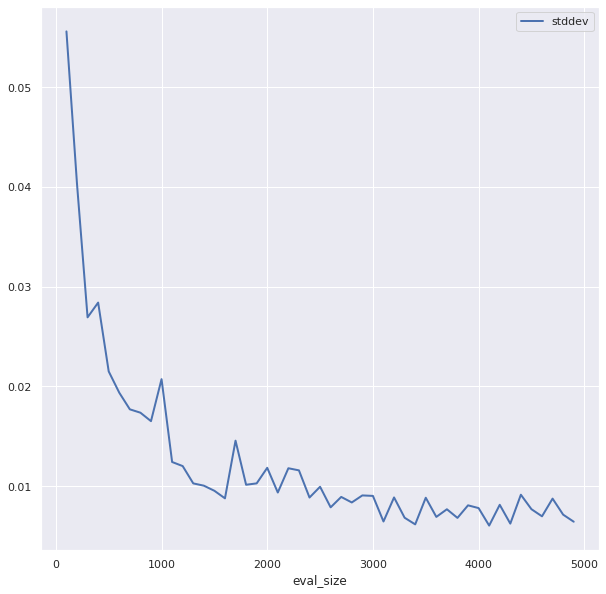

In [8]:
sizes = []
score_mean = []
score_stddev = []
for subset_size in range(100, 5000, 100): # 5000 here because that is the number of new examples we have
    sizes.append(subset_size)
    # compute variability of the eval metric at this subset size
    scores = []
    for x in range(1, 25):
        indices = np.random.choice(N_eval, size=subset_size, replace=False)
        scores.append(
            model.score(df_eval[indices], df_old.loc[N_train+indices, 'tip'])
        )
    score_mean.append(np.mean(scores))
    score_stddev.append(np.std(scores))
scores = pd.DataFrame.from_dict({
    'eval_size': sizes,
    'score': score_mean,
    'stddev': score_stddev
})
scores.plot(x='eval_size', y='stddev', linewidth=2);

Looking at this, it is clear that (on this problem) 3500 eval samples would be ideal, but 2000 is tolerable.

So, let's keep 2000 new examples aside for evaluation.

Take 3000 new examples for training

In [28]:
N_NEW = 2000

### Bridging schema using static approach

Estimate the probability of the different card types from the new data to find how to encode the 

In [10]:
df_train_new = df_new.loc[N_NEW:, :]
counts = df_train_new.groupby('payment_type').count()
counts

,order_amount,order_distance,tip
payment_type,,,
Cash,936,936,936
Credit,1280,1280,1280
Debit,602,602,602
Gift,182,182,182


In [12]:
num_credit = counts.loc['Credit', 'tip']
num_debit = counts.loc['Debit', 'tip']
num_gift = counts.loc['Gift', 'tip']
num_total = num_gift + num_debit + num_credit
imputed_value = [
    0,
    num_gift / num_total,
    num_debit / num_total,
    num_credit / num_total
]
print(imputed_value)

[0, 0.08817829457364341, 0.2916666666666667, 0.6201550387596899]


In [21]:
bridged_old = df_old.copy()
bridged_old['encoded_cash'] = 1  # default to cash
bridged_old['encoded_gift'] = 0  # default to cash
bridged_old['encoded_debit'] = 0  # default to cash
bridged_old['encoded_credit'] = 0  # default to cash
bridged_old.loc[bridged_old['payment_type'] == 'Card', 'encoded_cash'] = imputed_value[0]
bridged_old.loc[bridged_old['payment_type'] == 'Card', 'encoded_gift'] = imputed_value[1]
bridged_old.loc[bridged_old['payment_type'] == 'Card', 'encoded_debit'] = imputed_value[2]
bridged_old.loc[bridged_old['payment_type'] == 'Card', 'encoded_credit'] = imputed_value[3]
bridged_old.drop(columns='payment_type', inplace=True)
bridged_old[:10]

,order_amount,order_distance,tip,encoded_cash,encoded_gift,encoded_debit,encoded_credit
0,7.28,3.8,3.4,1,0.000000,0.000000,0.000000
1,11.34,2.1,3.3,1,0.000000,0.000000,0.000000
2,16.20,2.0,5.0,0,0.088178,0.291667,0.620155
3,17.87,1.3,3.3,0,0.088178,0.291667,0.620155
4,12.61,2.0,2.9,0,0.088178,0.291667,0.620155
5,9.42,1.7,2.7,1,0.000000,0.000000,0.000000
6,15.52,4.4,5.3,1,0.000000,0.000000,0.000000
7,5.45,3.4,2.5,0,0.088178,0.291667,0.620155
8,16.47,3.9,4.4,0,0.088178,0.291667,0.620155
9,16.15,4.5,4.7,0,0.088178,0.291667,0.620155


### Prepare new data

Because we explicitly encoded the fields for the bridged data, let's make sure to repeat this for the new data also.

In [22]:
encoded_new = df_new.copy()
encoded_new['encoded_cash'] = 0  # default to zero
encoded_new['encoded_gift'] = 0  # default to zero
encoded_new['encoded_debit'] = 0  # default to zero
encoded_new['encoded_credit'] = 0  # default to zero
encoded_new.loc[encoded_new['payment_type'] == 'Cash', 'encoded_cash'] = 1 # one-hot encode
encoded_new.loc[encoded_new['payment_type'] == 'Gift', 'encoded_gift'] = 1 # one-hot encode
encoded_new.loc[encoded_new['payment_type'] == 'Debit', 'encoded_debit'] = 1 # one-hot encode
encoded_new.loc[encoded_new['payment_type'] == 'Credit', 'encoded_credit'] = 1 # one-hot encode
encoded_new.drop(columns='payment_type', inplace=True)
encoded_new[:5]

,order_amount,order_distance,tip,encoded_cash,encoded_gift,encoded_debit,encoded_credit
0,11.11,4.0,4.8,0,0,0,1
1,7.95,2.1,1.8,0,1,0,0
2,6.90,1.6,2.2,1,0,0,0
3,11.38,3.5,3.5,0,0,1,0
4,19.20,5.0,6.3,1,0,0,0


In [ ]:
encoded_new_eval = encoded_new.loc[:N_NEW, :]
evalX = encoded_new_eval.loc[:, encoded_new_eval.columns != 'tip']
evalY = encoded_new_eval.loc[:, 'tip']
encoded_new_train = encoded_new.loc[N_NEW:, :]

### Augmented training dataset

Start with the 3000 new training examples, then add in bridged examples
from the old data as long as performance improves. This is a hyperparameter tuning operation.
Here's we'll simply do grid-search.

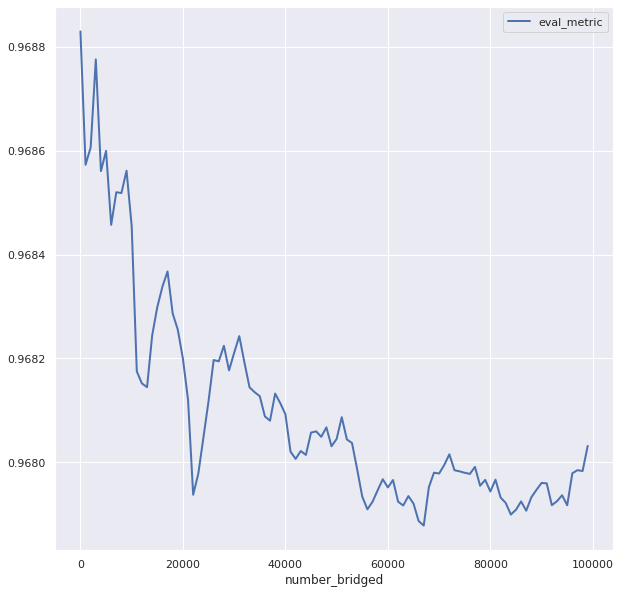

In [26]:
# add N bridged examples from old and train.
bridged_examples = []
scores = []
for num_bridged in range(0, 1000*100, 1000):
    bridged_examples.append(num_bridged)
    df_train = pd.concat([encoded_new_train, bridged_old[:num_bridged]], ignore_index=True)
    X = df_train.loc[:, df_train.columns != 'tip']
    Y = df_train.loc[:, 'tip']
    model.fit(X, Y)
    scores.append(model.score(evalX, evalY))

scores = pd.DataFrame.from_dict({
    'number_bridged': bridged_examples,
    'eval_metric': scores
})
scores.plot(x='number_bridged', y='eval_metric', linewidth=2);

Looks like we should aim for bridging the new dataset by adding 60,000 old examples.

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License